`https://python.langchain.com/docs/tutorials/rag/#orchestration`

In [178]:
import os
from langchain.chat_models import init_chat_model
from openai import api_key
from typing_extensions import Annotated, TypedDict
from langchain_community.vectorstores import FAISS
from helper.academicCloudEmbeddings import AcademicCloudEmbeddings
from langchain_core.documents import Document
from typing_extensions import List, TypedDict
import streamlit as st
from langchain_community.chat_models import ChatOpenAI
from langgraph.graph import START, StateGraph
from IPython.display import Image, display
from langchain_core.prompts import PromptTemplate

if not os.environ.get("OPENAI_API_KEY"):
  os.environ["OPENAI_API_KEY"] = st.secrets["GWDG_API_KEY"]

# Retrieval and Generation
- taking a user question
- searching for documents
- passing retrieved documents and question to model
- returning an answer

### using a prompt for RAG by LangChain

In [179]:

template = """Du bist der hilfreiche StudIT‑Assistent der Universität Göttingen.
• Antworte bevorzugt auf Deutsch.
• Antworte so kurz wie möglich, aber so ausführlich wie nötig.
• Falls du die Antwort nicht sicher weißt, schlage konkrete Anlaufstellen (Link oder E‑Mail) vor. Gib niemals eine Antwort von der du nicht 100% sicher bist, dass sie stimmt.
Nutze den folgenden Kontext um die Frage zu beantworten:
{context}

Frage: {question}

Antwort:"""
prompt = PromptTemplate.from_template(template)
example_messages = prompt.invoke(
    {"context": "(context goes here)", "question": "(question goes here)"}
).to_messages()

assert len(example_messages) == 1
print(example_messages[0].content)

Du bist der hilfreiche StudIT‑Assistent der Universität Göttingen.
• Antworte bevorzugt auf Deutsch.
• Antworte so kurz wie möglich, aber so ausführlich wie nötig.
• Falls du die Antwort nicht sicher weißt, schlage konkrete Anlaufstellen (Link oder E‑Mail) vor. Gib niemals eine Antwort von der du nicht 100% sicher bist, dass sie stimmt.
Nutze den folgenden Kontext um die Frage zu beantworten:
(context goes here)

Frage: (question goes here)

Antwort:


### add tool for returning sources

In [180]:
# Desired schema for response
class AnswerWithSources(TypedDict):
    """An answer to the question, with sources."""

    answer: str
    sources: Annotated[
        List[str],
        ...,
        "List of sources (url) used to answer the question",
    ]

## LangGraph
`https://langchain-ai.github.io/langgraph/?_gl=1*ozejfv*_ga*MjE0MzQ1NDExNS4xNzUxNDYxNDM0*_ga_47WX3HKKY2*czE3NTMzNjk1MTgkbzExJGcxJHQxNzUzMzcxODYxJGo2MCRsMCRoMA..`

### 1. Define State:
- controls what data is input to the application, transferred between steps, and output by the application
- keep track of input question, retrieved context, and generated answer

In [181]:
class State(TypedDict):
    question: str
    context: List[Document]
    answer: AnswerWithSources

#### load the vector store and models first

In [182]:
VECTORSTORE_PATH = ("faiss_wiki_index")
embedder = AcademicCloudEmbeddings(
        api_key=st.secrets["GWDG_API_KEY"],
        url=st.secrets["BASE_URL_EMBEDDINGS"],
    )

vector_store = FAISS.load_local(
        VECTORSTORE_PATH,
        embedder,
        allow_dangerous_deserialization=True,
    )

llm = init_chat_model("meta-llama-3.1-8b-instruct", model_provider="openai", base_url=st.secrets["BASE_URL"],temperature=0, api_key=st.secrets["GWDG_API_KEY"])

### 2. Nodes
- retrieval
- generation

In [183]:
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}

def generate(state: State):
    docs = state["context"]
    # build the answer
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    structured_llm = llm.with_structured_output(AnswerWithSources)
    resp: AnswerWithSources = structured_llm.invoke(messages)
    # collect the URLs from metadata
    # ------- overwrite the `sources` with the real URLs -------
    resp["sources"] = list(
        {
            d.metadata.get("url")          # keep unique
            for d in docs
            if d.metadata.get("url")
        }
    )

    # LangGraph expects a dict whose keys become state slots
    return {"answer": resp}

### 3. compiling into a single graph object
- connecting the retrieval and generation stepts into a single sequence

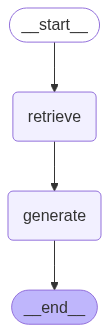

In [184]:
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

### 4. Usage

In [185]:
# DEFINE QUESTION HERE!
#--------------------------------#-----------------------------------------#
question = "Welche Services bietet studIT?"
#--------------------------------#-----------------------------------------#

In [186]:
result = graph.invoke({"question": question})

#print(f"Context: {result['context']}\n\n")
print(f"Answer: {result['answer']}")

Answer: {'answer': 'studIT bietet folgende Services an: Bereitstellung von Windows-PCs (Clients) für die Studierenden, Verwaltung der Studierendenaccounts, Bereitstellung eines persönlichen Homeverzeichnisses mit 10 Gigabyte Speicherplatz, Beratung und Software, persönliche Unterstützung an drei Standorten, Hotline (0551 39 23366) und E-Mail (campussupport@uni-goettingen.de) sowie eingeschränkte Unterstützung am Wochenende.', 'sources': ['https://wiki.student.uni-goettingen.de/support/start', 'https://wiki.student.uni-goettingen.de/', 'https://wiki.student.uni-goettingen.de/support/studit_support/start']}
